# Self-driving labortory data

BO optimising a scalable spray coating process, with the target being maximising conductivity.

Link: https://www.cell.com/cell-reports-physical-science/pdf/S2666-3864(23)00185-6.pdf

Seven input variables were manipulated: two ink composition variables (DMSO content and solute concentration) and five spray-coating
variables (ink flow rate, airflow rate, number of passes, height, and hotplate temperature)

Loading the data and filtering for target and varying input variables.

Variables needed for analysis:

- conductivity_avg * 1e-6 (target)
- DMSO_content_realized (ink composition)
- concentration_realized (ink composition)
- combustion_temp_realized (spray-coating)
- air_flow_rate_realized (spray-coating)
- spray_flow_rate_realized (spray-coating)
- spray_height_realized (spray-coating)
- num_passes_realized (spray-coating)

Using realized as these are the actual function values.




In [ ]:
# Imports for analysis
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence

# Imports for GP
import torch
import botorch as bo
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Hackathon_BO_interpretation/compiled_optimization_data.csv'

df = pd.read_csv(data_path)

BO_cols = ['sample','beta','conductivity_avg','DMSO_content_realized','concentration_realized','combustion_temp_realized','air_flow_rate_realized','spray_flow_rate_realized','spray_height_realized','num_passes_realized']

BO_data = df[BO_cols]

BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper

#BO_data.head()

Mounted at /content/drive


<ipython-input-4-cfb913fe48d0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper


In [ ]:
max_conductivity_avg = np.max(BO_data['scaled_conductivity_avg'])

print(BO_data[BO_data['scaled_conductivity_avg'] == max_conductivity_avg])


    sample      beta  conductivity_avg  DMSO_content_realized  \
59      61  2.00E-01      4.217336e+06               0.299565   

    concentration_realized  combustion_temp_realized  air_flow_rate_realized  \
59                0.017578                263.492945               91.840492   

    spray_flow_rate_realized  spray_height_realized  num_passes_realized  \
59                  0.004712              10.323451                  7.0   

    scaled_conductivity_avg  
59                 4.217336  


# GP model: fixed noise

Recreating the original method: The Bayesian optimization performed using the Botorch Python package31 and happened in two steps. First, a surrogate Gaussian process (GP) regression model was built over all existing data. The data covariates were normalized to the unit cube and outcomes were standardized (zero mean, unit variance). A fixed-noise GP model was used for the surrogate model with standard deviation of the input data estimated to be of 0.2 MS/m. All other hyperparameters for the GP model were default.

146


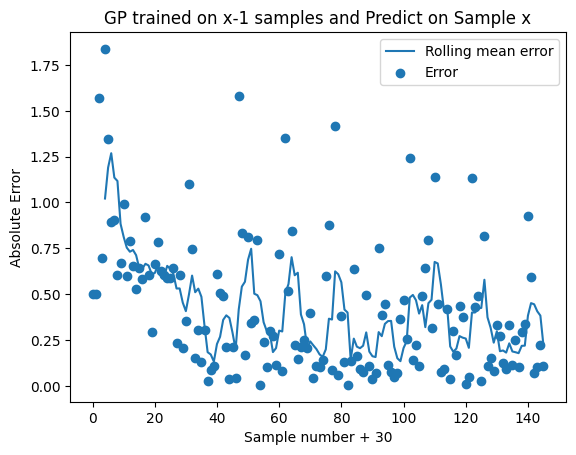

In [ ]:
# Fitting the GP on subsets of the data

features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

# Data processcing
X = BO_data[features]
y = BO_data[target]
std = 0.2
X_normalized = (X - X.min()) / (X.max() - X.min()) # Norm to (0,1)
y_standardized = (y - y.mean()) / y.std() # N(0,1)
X_tensor = torch.tensor(X_normalized.values, dtype=torch.double)
y_tensor = torch.tensor(y_standardized.values, dtype=torch.double)
mse_list = []
err_list = []
y_pred_list = []

for i in range(30, len(y_tensor)-1):

  X_subset = X_tensor[:i,:]
  y_subset = y_tensor[:i]

  X_subset = (X_subset - X_subset.min()) / (X_subset.max() - X_subset.min()) # Norm to (0,1)
  Y_subset = (y_subset - y_subset.mean()) / y_subset.std() # N(0,1)


  X_pred_val = X_tensor[i:i+1,:]
  Y_true = y_tensor[i:i+1]

  train_Yvar = torch.full_like(Y_subset.unsqueeze(-1), std)
  gp = bo.models.SingleTaskGP(X_subset, Y_subset.unsqueeze(-1), train_Yvar=train_Yvar) # Train the model

  with torch.no_grad():
      samples = gp.posterior(X_pred_val).sample(sample_shape=torch.Size([1000]))  # Sample from posterior

  y_pred = samples.mean(dim=0)
  y_pred_list.append(y_pred)
  err = np.abs(y_pred - Y_true)
  err_list.append(err)


print(len(err_list))
err_list_scalar = [err.item() for err in err_list]
window_size = 5
rolling_mean = pd.Series(err_list_scalar).rolling(window=window_size).mean()

plt.xlabel('Sample number + 30')
plt.ylabel('Absolute Error')
plt.title('GP trained on x-1 samples and Predict on Sample x')

plt.plot(rolling_mean, label='Rolling mean error')
plt.scatter(range(len(err_list_scalar)), err_list_scalar, label='Error', marker='o')

plt.legend()
plt.show()


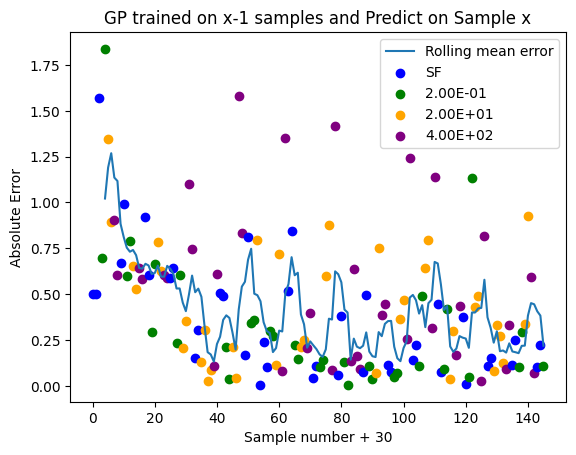

In [ ]:
err_list_scalar = [err.item() for err in err_list]
window_size = 5
rolling_mean = pd.Series(err_list_scalar).rolling(window=window_size).mean()

plt.xlabel('Sample number + 30')
plt.ylabel('Absolute Error')
plt.title('GP trained on x-1 samples and Predict on Sample x')

plt.plot(rolling_mean, label='Rolling mean error')

category_color_map = {
    'random': 'red',
    'SF': 'blue',
    '2.00E-01': 'green',
    '2.00E+01': 'orange',
    '4.00E+02': 'purple'
}

beta_data = df['beta'][31:]

plotted_categories = set()

for i, (category, error) in enumerate(zip(beta_data, err_list_scalar)):
    color = category_color_map.get(category, 'black')
    plt.scatter(i, error, color=color, label=None, marker='o')

    # Add legend entry only if the category is not plotted before
    if category not in plotted_categories:
        plt.scatter([], [], color=color, label=category, marker='o')
        plotted_categories.add(category)

plt.legend()
plt.show()

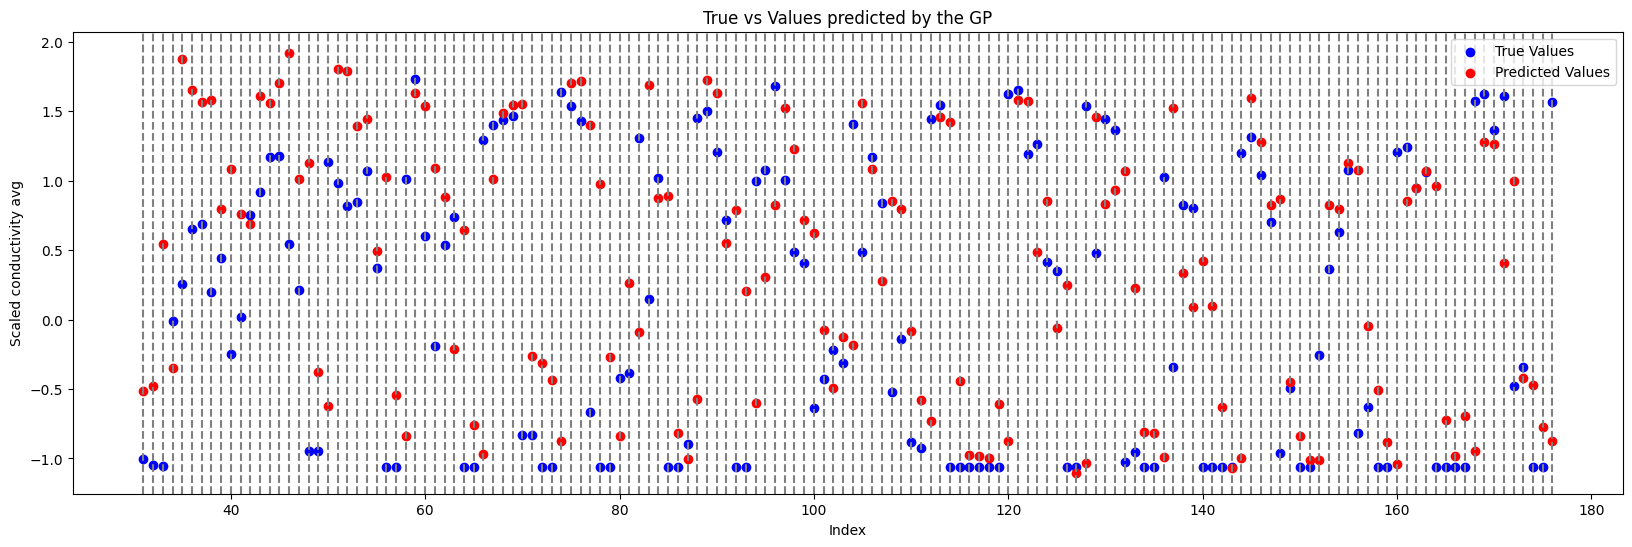

In [ ]:
y_pred_scalar = [y.item() for y in y_pred_list]
df_predicted = pd.DataFrame({'y_predicted': y_pred_scalar})
filtered_df = y_standardized.iloc[31:]

df_predicted_array = df_predicted['y_predicted'].values
filtered_df_array = filtered_df.values
# Scatter plot
plt.figure(figsize=(20, 6))

plt.scatter(filtered_df.index, filtered_df_array, color='blue', label='True Values')
plt.scatter(filtered_df.index, df_predicted_array, color='red', label='Predicted Values')
for i in range(len(filtered_df.index)):
  plt.axvline(x=filtered_df.index[i], linestyle='--', color='gray')
plt.xlabel('Index')
plt.ylabel('Scaled conductivity avg')
plt.title('True vs Values predicted by the GP')
plt.legend()
plt.show()


# Time evolving GP cross-sections

Investigation to how the cross section of the GP model changes over the course of the BO campaign. Does this evolution match the prior beliefs of the scientist.

160


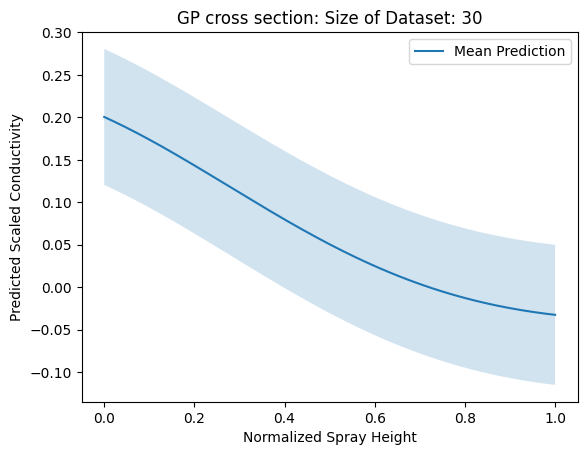

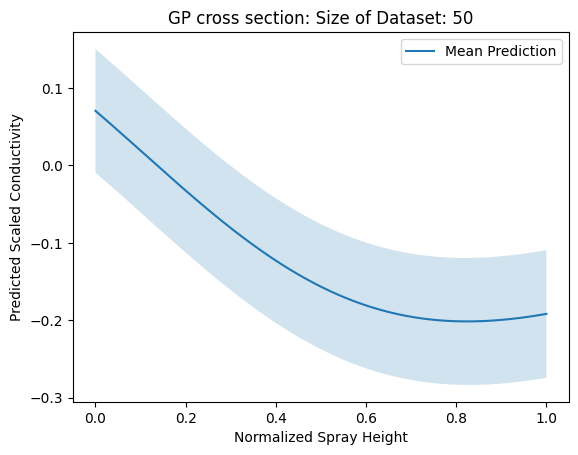

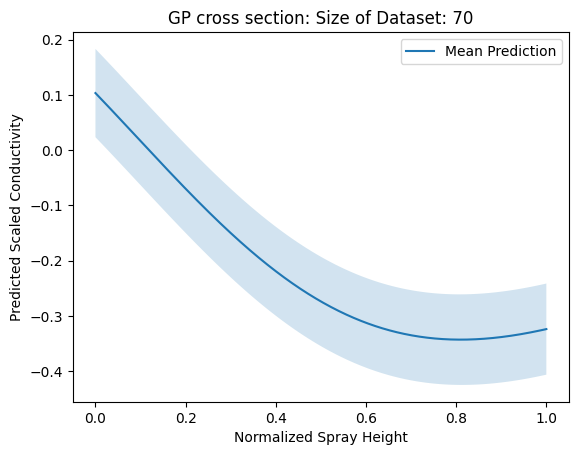

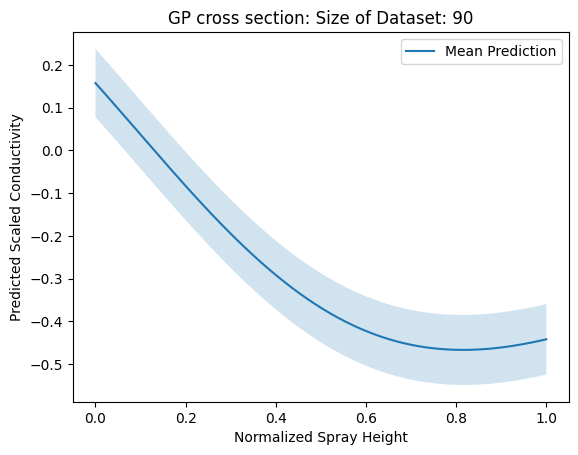

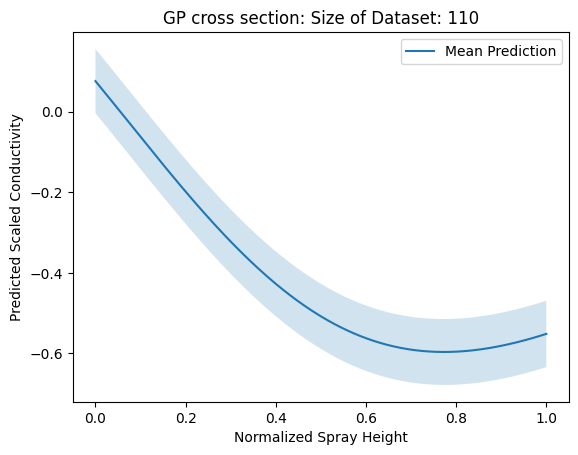

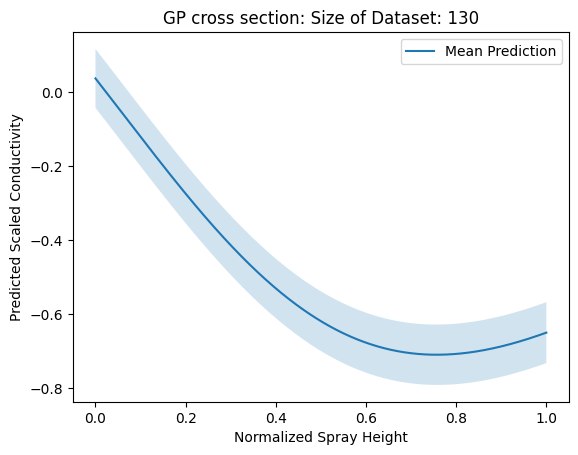

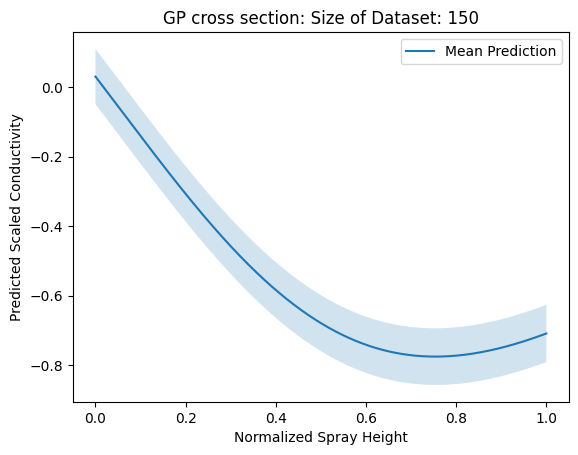

In [ ]:
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

X = BO_data[features]
y = BO_data[target]
std = 0.2
X_tensor = torch.tensor(X.values, dtype=torch.double)
y_tensor = torch.tensor(y.values, dtype=torch.double)
print(len(X_tensor)-17)

step_size = 20
for i in range(30, len(X_tensor)-17, step_size):
  X_subset = X_tensor[:i, :]
  y_subset = y_tensor[:i]
  # X_subset = X_tensor
  # y_subset = y_tensor

  X_subset_normed = (X_subset - X_subset.min()) / (X_subset.max() - X_subset.min()) # Norm to (0,1)
  Y_subset_normed = (y_subset - y_subset.mean()) / y_subset.std() # N(0,1)

  train_Yvar = torch.full_like(Y_subset_normed.unsqueeze(-1), std)
  # std = torch.std(Y_subset_normed)  # Estimate the standard deviation from the training data
  # train_Yvar = torch.full_like(Y_subset_normed.unsqueeze(-1), std)
  gp = bo.models.SingleTaskGP(X_subset_normed, Y_subset_normed.unsqueeze(-1), train_Yvar=train_Yvar) # Train the model on subset

  constant_features = {
      'DMSO_content_realized': 0.5,
      'concentration_realized': 0.5,
      'combustion_temp_realized': 0.5,
      'air_flow_rate_realized': 0.5,
      'spray_flow_rate_realized': 0.5,
      'num_passes_realized': 0.5
  }

  num = 1000
  constant_features_tensor = torch.zeros((num, len(features)), dtype=torch.double)
  spray_height_values = torch.linspace(0, 1, num).unsqueeze(1)

  for i, feat in enumerate(features):
      if feat == 'spray_height_realized': # Feature here
          constant_features_tensor[:, i] = spray_height_values.squeeze()
      else:
          constant_features_tensor[:, i] = constant_features[feat]

  with torch.no_grad():
      pred = gp.posterior(constant_features_tensor)
      mean = pred.mean
      st = pred.variance.sqrt()

  # Plot the results
  plt.figure()
  plt.plot(spray_height_values.numpy(), mean.numpy(), label='Mean Prediction')
  plt.fill_between(spray_height_values.numpy().squeeze(),
                     (mean - st/10).numpy().squeeze(),
                     (mean + st/10).numpy().squeeze(),
                     alpha=0.2)

  plt.xlabel('Normalized Spray Height')
  plt.ylabel('Predicted Scaled Conductivity')
  plt.title(f'GP cross section: Size of Dataset: {len(X_subset)}')
  plt.legend()

plt.show()

160


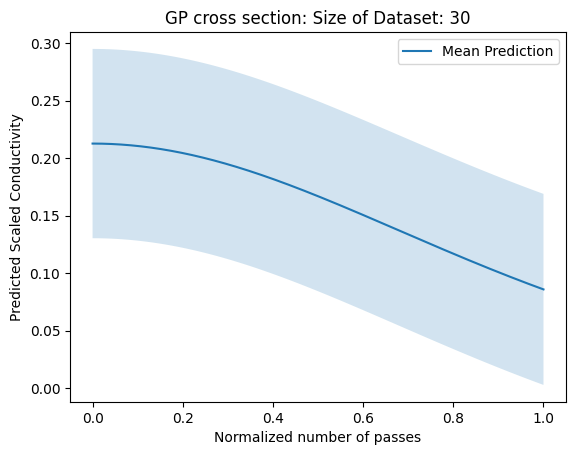

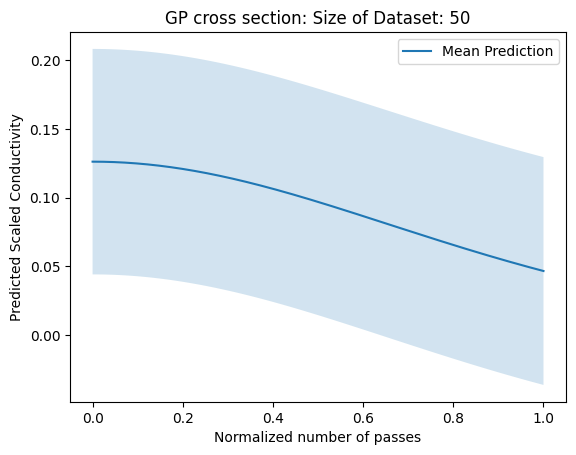

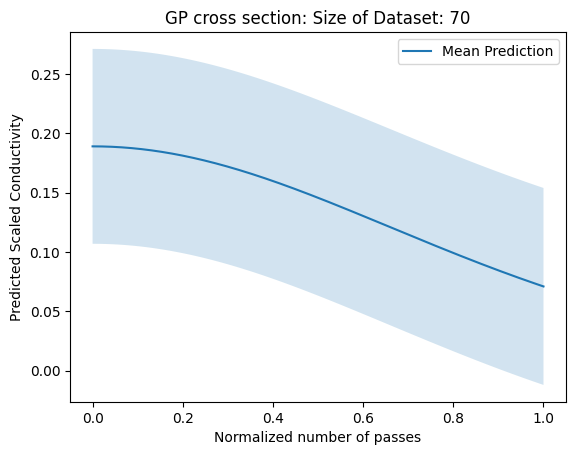

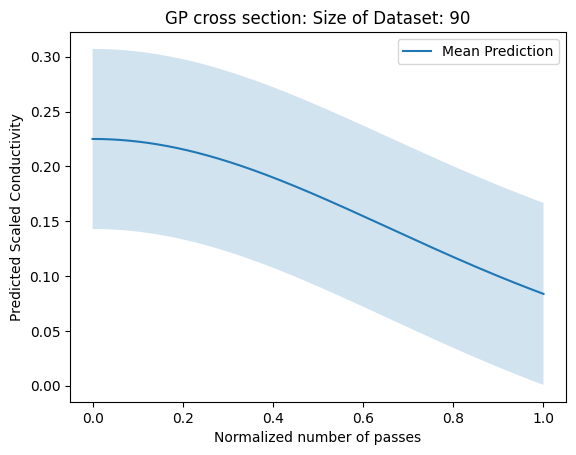

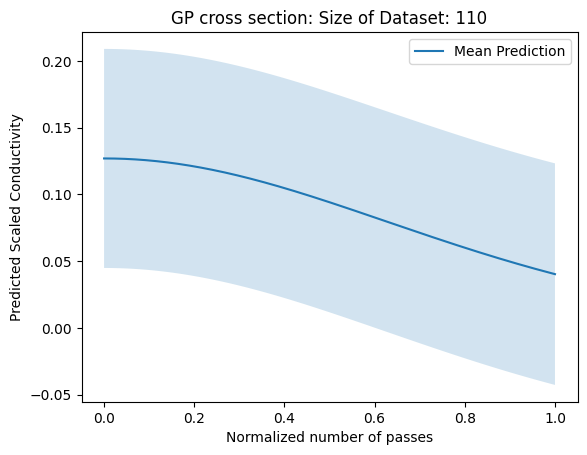

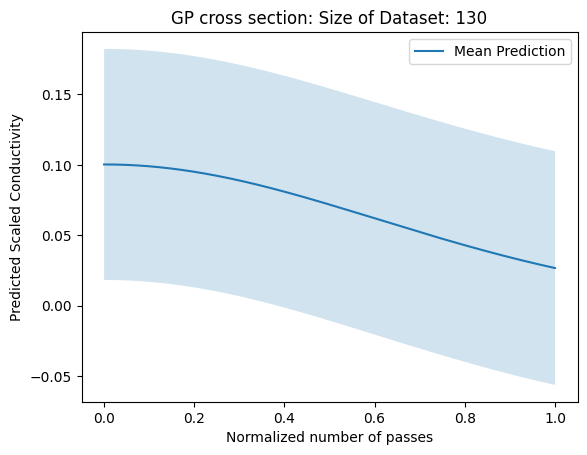

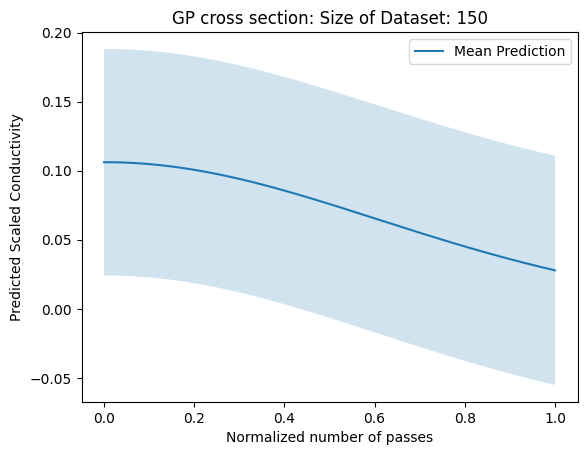

In [ ]:
# Can change the feature cross section bellow:
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

X = BO_data[features]
y = BO_data[target]
std = 0.2
X_tensor = torch.tensor(X.values, dtype=torch.double)
y_tensor = torch.tensor(y.values, dtype=torch.double)
print(len(X_tensor)-17)

step_size = 20
for i in range(30, len(X_tensor)-17, step_size):
  X_subset = X_tensor[:i, :]
  y_subset = y_tensor[:i]
  # X_subset = X_tensor
  # y_subset = y_tensor

  X_subset_normed = (X_subset - X_subset.min()) / (X_subset.max() - X_subset.min()) # Norm to (0,1)
  Y_subset_normed = (y_subset - y_subset.mean()) / y_subset.std() # N(0,1)

  train_Yvar = torch.full_like(Y_subset_normed.unsqueeze(-1), std)
  # std = torch.std(Y_subset_normed)  # Estimate the standard deviation from the training data
  # train_Yvar = torch.full_like(Y_subset_normed.unsqueeze(-1), std)
  gp = bo.models.SingleTaskGP(X_subset_normed, Y_subset_normed.unsqueeze(-1), train_Yvar=train_Yvar) # Train the model on subset

  constant_features = {
      'DMSO_content_realized': 1,
      'concentration_realized': 1,
      'combustion_temp_realized': 0.5,
      'air_flow_rate_realized': 0.9,
      'spray_flow_rate_realized': 0.1,
      'spray_height_realized': 0,
      'num_passes_realized': 0.6
  }

  num = 1000
  constant_features_tensor = torch.zeros((num, len(features)), dtype=torch.double)
  changing_values = torch.linspace(0, 1, num).unsqueeze(1)

  for i, feat in enumerate(features):
      if feat == 'concentration_realized': # Feature here
          constant_features_tensor[:, i] = changing_values.squeeze()
      else:
          constant_features_tensor[:, i] = constant_features[feat]

  with torch.no_grad():
      pred = gp.posterior(constant_features_tensor)
      mean = pred.mean
      st = pred.variance.sqrt()

  # Plot the results
  plt.figure()
  plt.plot(changing_values.numpy(), mean.numpy(), label='Mean Prediction')
  plt.fill_between(changing_values.numpy().squeeze(),
                     (mean - st/10).numpy().squeeze(),
                     (mean + st/10).numpy().squeeze(),
                     alpha=0.2)

  plt.xlabel('Normalized number of passes')
  plt.ylabel('Predicted Scaled Conductivity')
  plt.title(f'GP cross section: Size of Dataset: {len(X_subset)}')
  plt.legend()

plt.show()

# Plotting and visualization

First plotting the scaled conductivity (the target) against the experiment number (sample). Then looking at the following models to predict the conductivity from the seven features used in the BO.
* A linear regression model to get some feature importance rankings. This will not capture non linear dependencies between the variables.
* Random forrest model to better capture nonlinear dependencies. The partial dependency plots show how the target prediction changes when varying the features and holding the others constant.


In [ ]:
plt.plot(BO_data['sample'], BO_data['scaled_conductivity_avg'])
plt.title('Conductivity Analysis')
plt.xlabel('Sample')
plt.ylabel('Scaled Conductivity')
plt.axhline(y=4.1, color='r', linestyle='--', label='Champion Conductivity')
plt.axhline(y=2.0, color='g', linestyle='--', label='Previous Best')
plt.legend()
plt.show()

In [ ]:
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

X = BO_data[features]
y = BO_data[target]

scaler = StandardScaler()
X_norm = scaler.fit_transform(X) # Norm of the variables for better scaling

# Train a linear regression model
model_linear = LinearRegression()
model_linear.fit(X_norm, y)

# Get coefficients of the model (indicative of feature importance)
feature_importance = pd.Series(model_linear.coef_, index=features).sort_values(ascending=False)

print("Feature Importance Rankings:\n")
print(feature_importance)

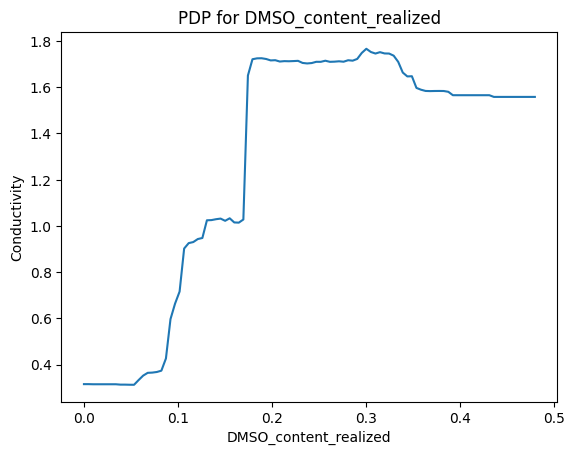

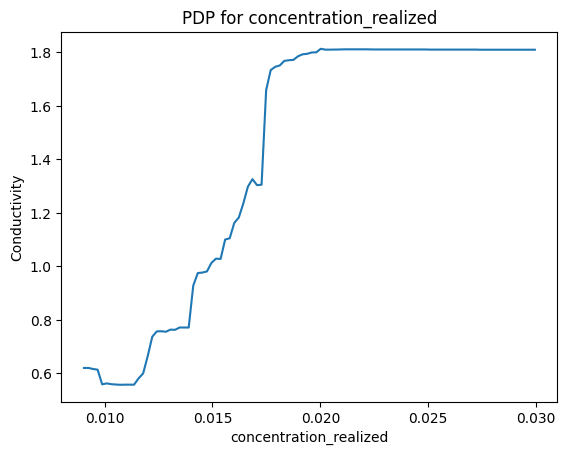

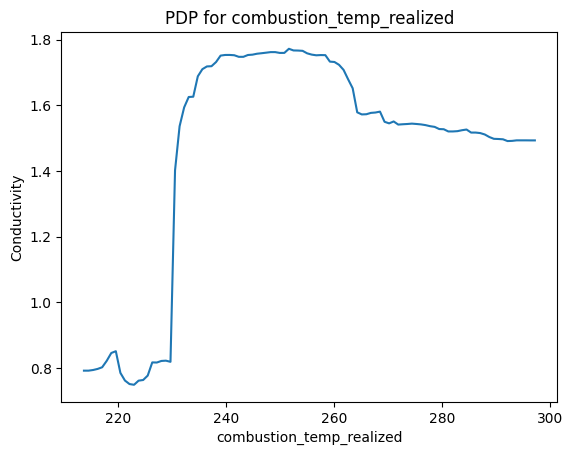

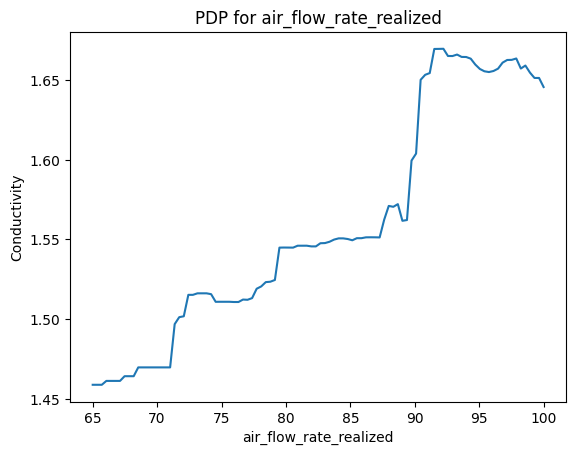

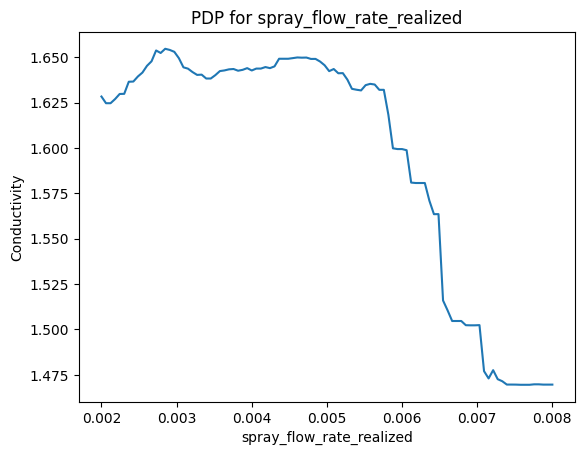

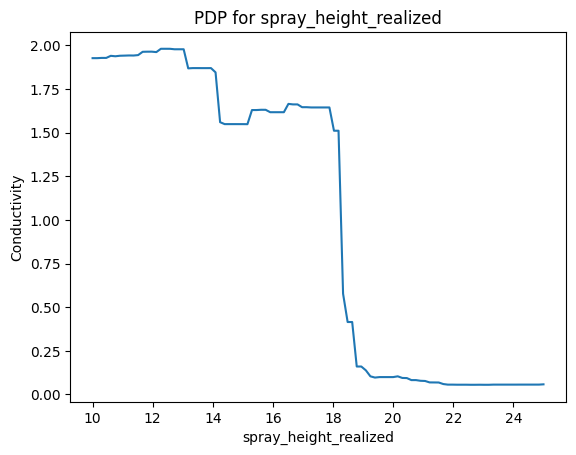

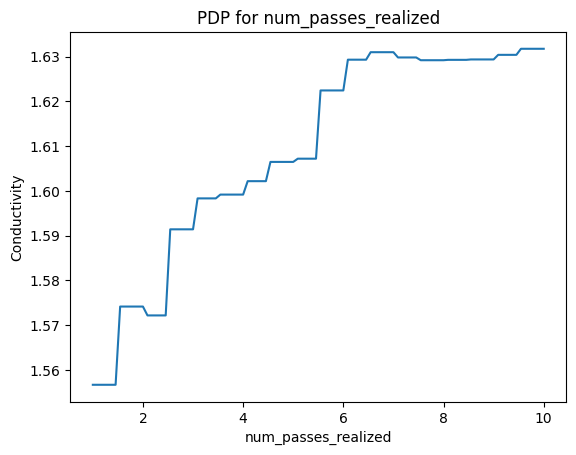

In [ ]:
# Random Forest model
model_RF = RandomForestRegressor(n_estimators=100, random_state=10)
model_RF.fit(X, y)

# Range of values for each feature
feature_ranges = {}
for feature in features:
    feature_ranges[feature] = np.linspace(np.min(X[feature]), np.max(X[feature]), num=100)

# Create PDPs for each feature
for feature in features:
    pdp_values = []
    for value in feature_ranges[feature]:
        X_t = X.copy()
        X_t[feature] = value
        pdp_value = np.mean(model_RF.predict(X_t))
        pdp_values.append(pdp_value)

    # Plot PDP
    plt.plot(feature_ranges[feature], pdp_values)
    plt.xlabel(feature)
    plt.ylabel("Conductivity")
    plt.title(f'PDP for {feature}')
    plt.show()

# Sensitivity analysis

The PDP plots show that all the variables have a non-linear relationship with conductivity.
A GP model trained on the full dataset is most appropriate for capturing this and for consistency with the original model.

21


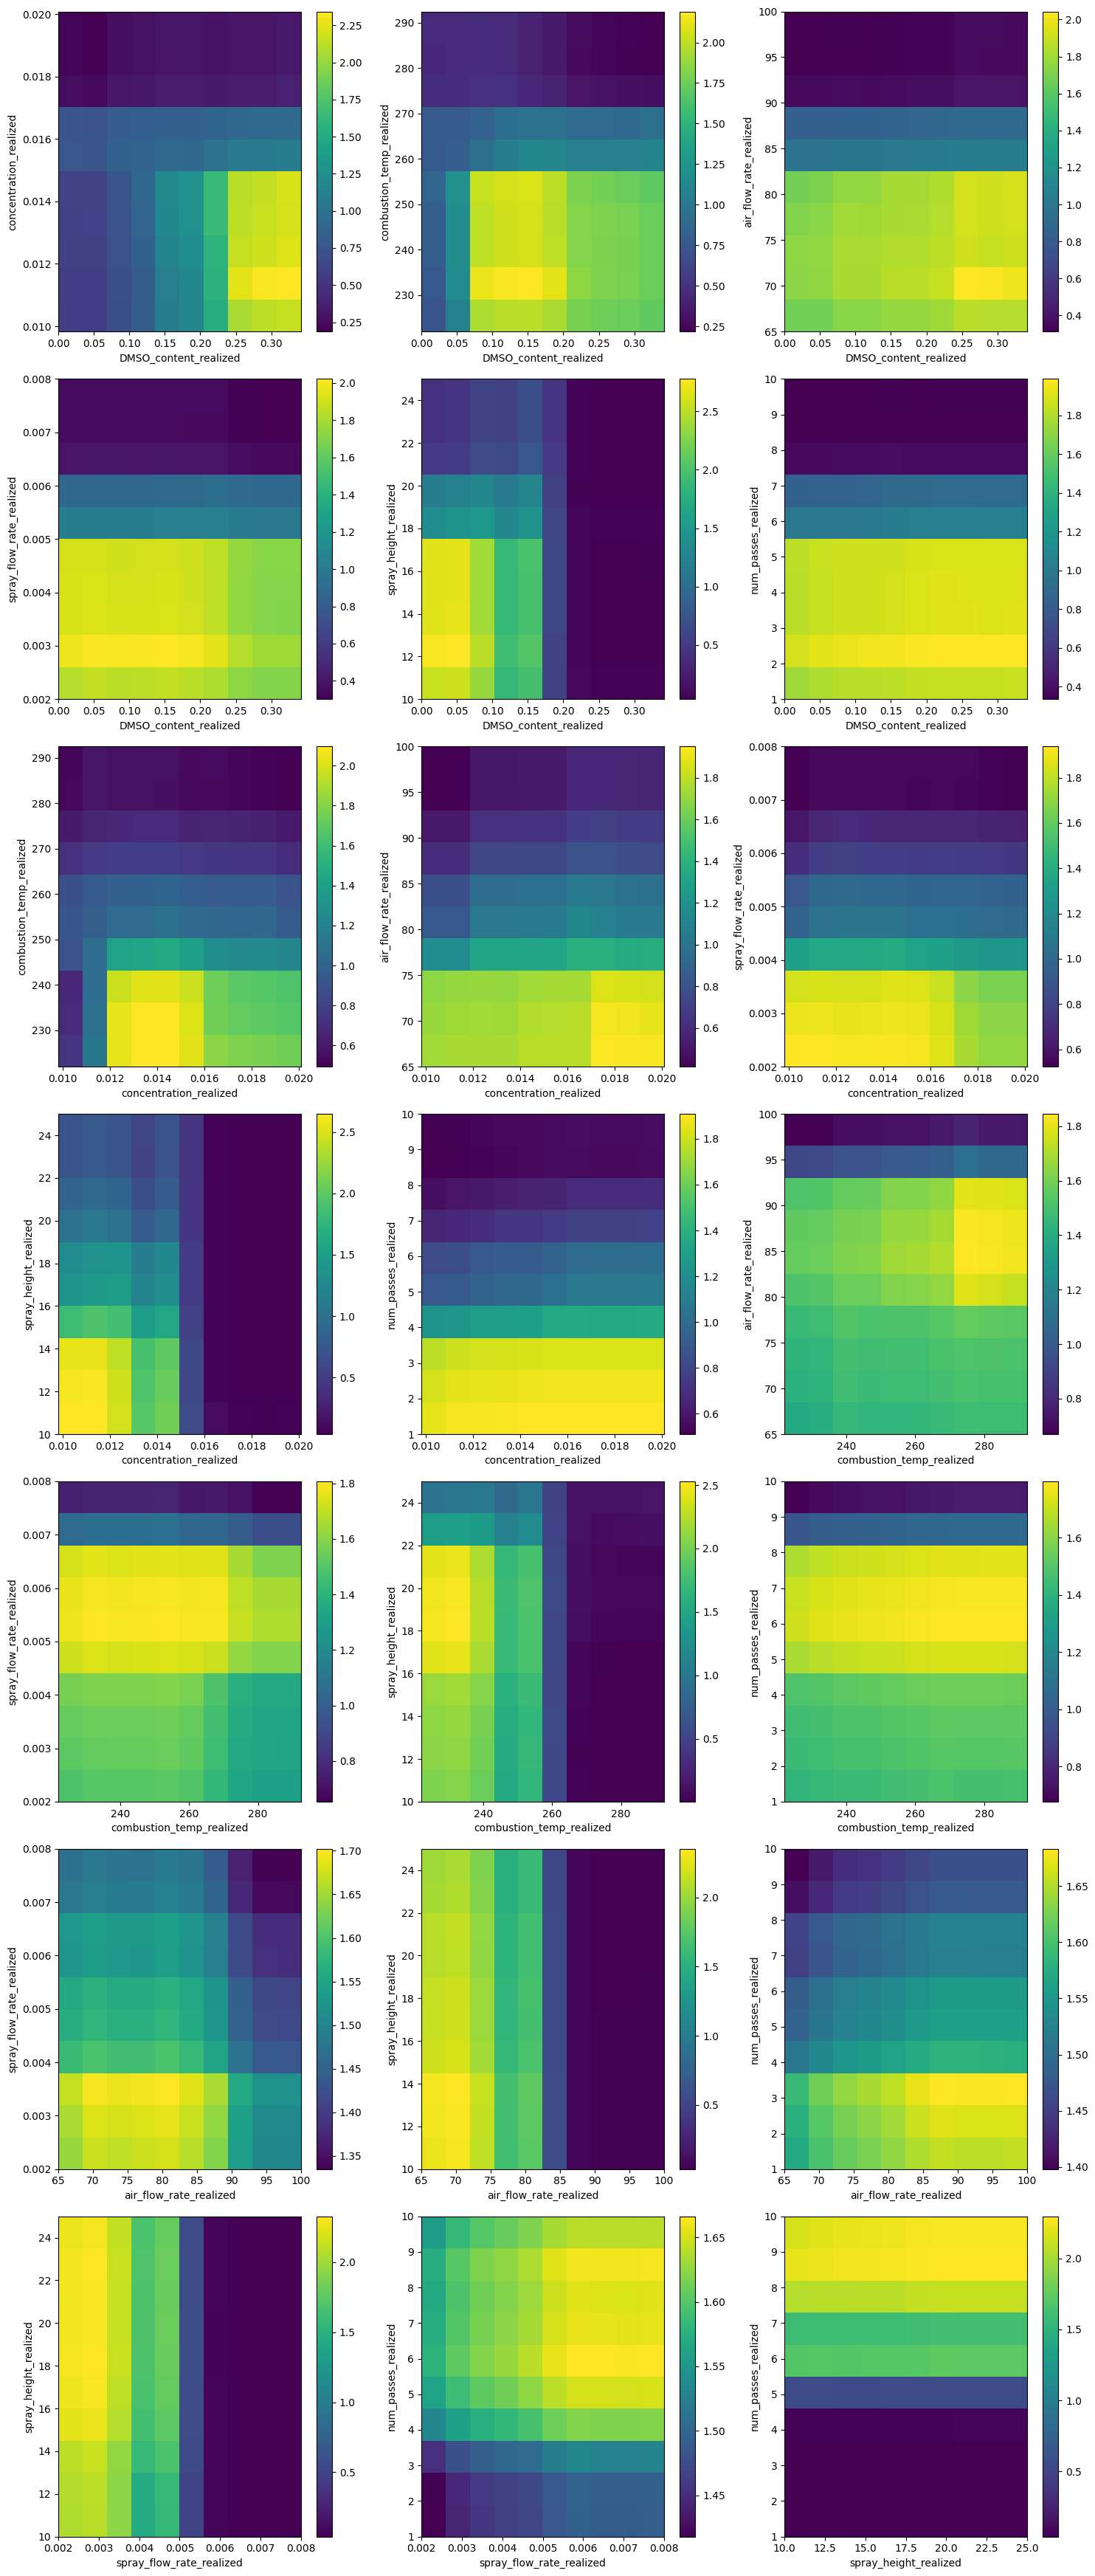

In [ ]:
# Using the average as the fixed values.
feature_pairs = list(combinations(features, 2))  # All pairs of features
print(len(feature_pairs))  # 7 choose 2

fig, axs = plt.subplots(7, 3, figsize=(15, 35))

for i, (feature1, feature2) in enumerate(feature_pairs):

    num = 10
    pdp = partial_dependence(model_RF, X, features=[feature1, feature2], grid_resolution=num)['average']  # model_RF for random forrest gp_model for GP
    vals = partial_dependence(model_RF, X, features=[feature1, feature2], grid_resolution=num)['values']  #

    pdp_reshaped = pdp.reshape((num, num))

    row = i // 3
    col = i % 3

    im = axs[row, col].imshow(pdp_reshaped, cmap='viridis', aspect='auto', extent=[vals[0][0], vals[0][-1], vals[1][0], vals[1][-1]])
    axs[row, col].set_xlabel(feature1)
    axs[row, col].set_ylabel(feature2)
    fig.colorbar(im, ax=axs[row, col])

plt.tight_layout()
plt.show()

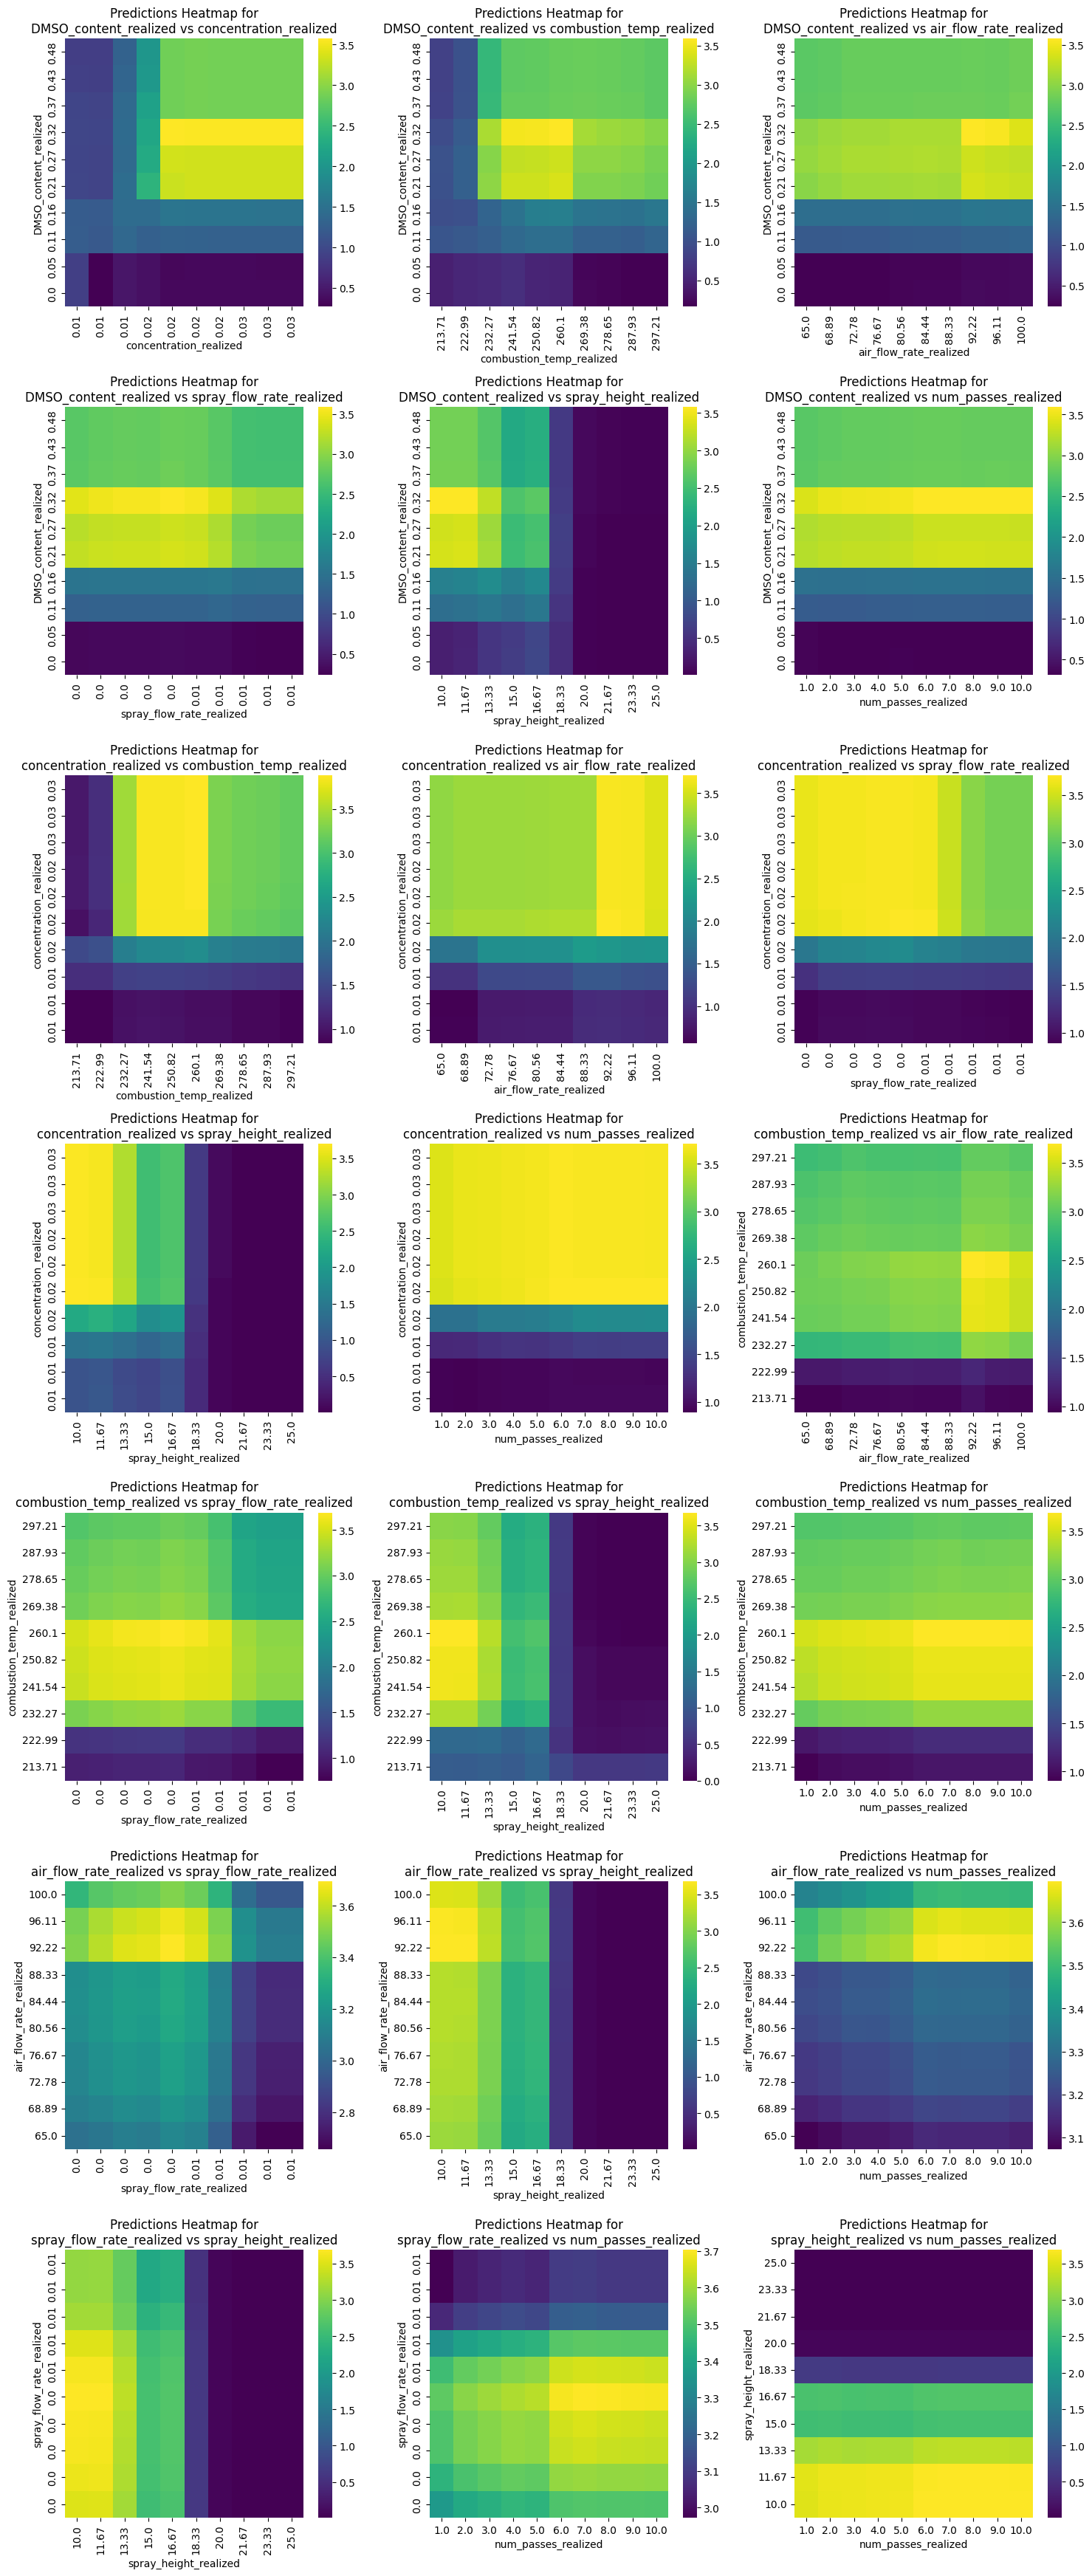

In [ ]:
# Using the max as the fixed values
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

max_values = {
    'DMSO_content_realized': 0.299565,
    'concentration_realized': 0.017578,
    'combustion_temp_realized': 263.492945,
    'air_flow_rate_realized': 91.840492,
    'spray_flow_rate_realized': 0.004712,
    'spray_height_realized': 10.323451,
    'num_passes_realized': 7.0
}

X_max = {feature: max_value for feature, max_value in max_values.items()}

feature_pairs = list(combinations(features, 2))  # All pairs of features

fig, axs = plt.subplots(7, 3, figsize=(15, 35))

for idx, pair in enumerate(feature_pairs):

    # Reset X_max to its original values
    X_max = {feature: max_value for feature, max_value in max_values.items()}

    # Reverse the order of feature1_values
    feature1_values = np.linspace(np.min(X[pair[0]]), np.max(X[pair[0]]), 10)
    feature2_values = np.linspace(np.min(X[pair[1]]), np.max(X[pair[1]]), 10)
    feature1_values = np.flipud(feature1_values)

    predictions = np.zeros((len(feature1_values), len(feature2_values)))

    for i, val1 in enumerate(feature1_values):
        for j, val2 in enumerate(feature2_values):

            X_max[pair[0]] = val1
            X_max[pair[1]] = val2
            X_pred = pd.DataFrame(data=[[X_max[feature] for feature in max_values.keys()]], columns=max_values.keys())
            prediction = model_RF.predict(X_pred)
            predictions[i, j] = prediction[0]

    sns.heatmap(predictions, cmap='viridis', annot=False, ax=axs[idx // 3, idx % 3],
                xticklabels=feature2_values.round(2), yticklabels=feature1_values.round(2))
    axs[idx // 3, idx % 3].set_xlabel(pair[1])
    axs[idx // 3, idx % 3].set_ylabel(pair[0])
    axs[idx // 3, idx % 3].set_title('Predictions Heatmap for\n{} vs {}'.format(pair[0], pair[1]))

plt.tight_layout()
plt.show()

# Variogram sensitivity analysis

This provides a new framework for comprehensive, robust, and efficient
global sensitivity analysis:

In [ ]:
# TODO: magnitude of the predicted global effect of each component employ the VARS method see ref

In [ ]:
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

X = BO_data[features]
y = BO_data[target]

